In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
data = pd.read_csv('final-data.csv')

In [4]:
data['Week Endings'] = pd.to_datetime(data['Week Endings'], errors = 'raise')
data = data.sort_values(by='Week Endings', ascending=True)

In [5]:
# Truncating data after the release of the lion king movie
lk_release = datetime.date(2019, 7, 19)
boolean_mask = data['Week Endings'].dt.date < lk_release

In [6]:
# Data after the series has been truncated
print(data[boolean_mask].tail(5).to_string())
print(data[boolean_mask].shape)

    Week Endings  Avg Ticket Price ($)  Top Ticket Price ($)  Seats Sold  Seats in Theatre   % Cap
141   2019-06-16                171.79                 225.0       13565              1696   99.98
140   2019-06-23                178.53                 225.0       13569              1696  100.01
139   2019-06-30                179.18                 225.0       13550              1696   99.87
138   2019-07-07                190.91                 225.0       13519              1696   99.64
137   2019-07-14                187.67                 225.0       12759              1696   94.04
(1129, 6)


In [7]:
data = data[boolean_mask]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129 entries, 1265 to 137
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Week Endings          1129 non-null   datetime64[ns]
 1   Avg Ticket Price ($)  1129 non-null   float64       
 2   Top Ticket Price ($)  1129 non-null   float64       
 3   Seats Sold            1129 non-null   int64         
 4   Seats in Theatre      1129 non-null   int64         
 5   % Cap                 1129 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 61.7 KB


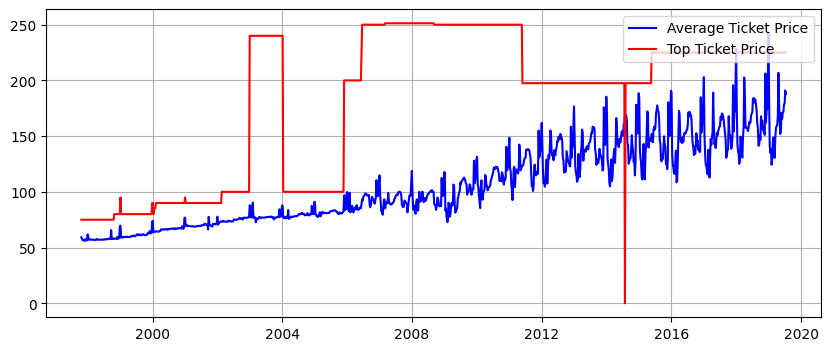

In [9]:
# Some basic plotting to check data and 
# data scale to determine whether data needs to be normalised or not
# before being used with the sequence model for prediction
# year = np.array(range(data.shape[0])) + 757
time = data['Week Endings']
plt.figure(figsize=(10, 4))
plt.grid(True)
plt.plot(time, data['Avg Ticket Price ($)'], color='b', label="Average Ticket Price")
plt.plot(time, data['Top Ticket Price ($)'], color='r', label="Top Ticket Price")
plt.legend(loc=1)
plt.show()

In [10]:
series = data['Avg Ticket Price ($)']
split_time = int(len(series) * 0.85)

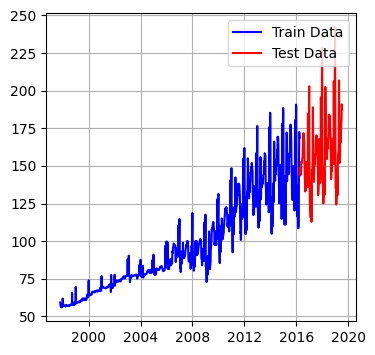

In [11]:
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train, x_train, color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

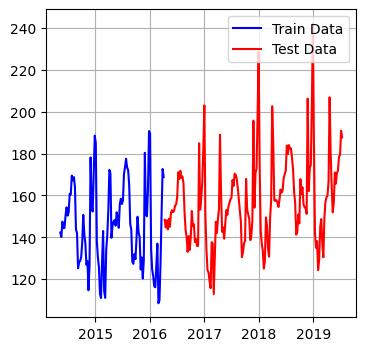

In [12]:
# Visualizing each seasonal cycle to decide window_size param
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

plt.figure(figsize=(4, 4))
plt.grid(True)
plt.plot(time_train[-100:], x_train[-100:], color='b', label="Train Data")
plt.plot(time_valid, x_valid, color='r', label="Test Data")
plt.legend(loc=1)
plt.show()

# Utilities:

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

In [173]:
# Defining parameters
window_size = 56
batch_size = 28
shuffle_buffer = 1000

In [174]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [175]:
# Checking the windowed training set:
list(train_set.take(2).as_numpy_iterator())

[(array([[ 83.9 ,  86.67,  94.8 , ..., 101.49, 106.78, 105.89],
         [ 93.66,  90.67,  93.15, ...,  83.73,  83.66,  86.03],
         [ 84.03,  83.85,  85.15, ...,  88.71,  89.08,  90.02],
         ...,
         [137.8 , 137.25, 138.23, ..., 149.23, 146.99, 152.02],
         [ 57.66,  57.28,  57.68, ...,  61.15,  61.82,  61.16],
         [ 77.21,  75.16,  76.71, ...,  79.6 ,  79.32,  80.96]]),
  array([101.57,  94.26,  90.19, 133.63, 127.89,  77.83,  83.4 , 140.37,
         126.93,  75.24, 166.19, 109.49,  73.3 , 117.15,  99.82, 111.81,
          79.81, 104.29, 190.72,  67.08,  90.24, 147.5 , 107.76, 120.49,
         117.47, 150.08,  60.91,  79.37])),
 (array([[70.12, 69.85, 70.01, ..., 75.11, 75.03, 74.73],
         [61.58, 61.13, 62.  , ..., 66.78, 66.61, 66.89],
         [72.29, 72.87, 73.39, ..., 76.88, 90.39, 76.91],
         ...,
         [64.37, 64.3 , 64.57, ..., 69.  , 68.93, 68.96],
         [68.95, 69.3 , 69.27, ..., 73.46, 73.57, 73.56],
         [91.04, 90.81, 79.86, ..

In [176]:
# Creating the validation dataset
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

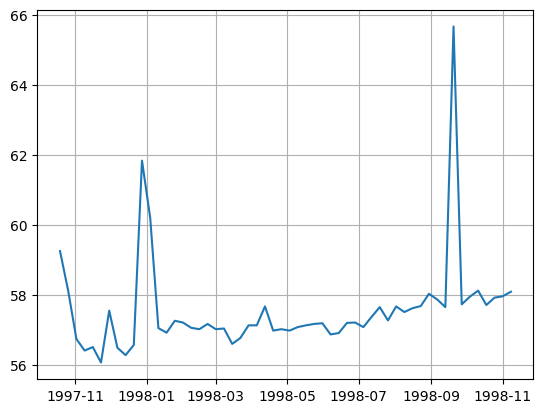

<Figure size 600x400 with 0 Axes>

In [177]:
plt.plot(time_train[:window_size], x_train[:window_size])
plt.grid(True)
plt.figure(figsize=(6, 4))
plt.show()

In [246]:
# Resetting any prior defined model weight data
tf.keras.backend.clear_session()

# Defining the model
l0 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(30),
    tf.keras.layers.Dense(15, activation='relu'),
    l0,
    tf.keras.layers.Lambda(lambda x: x * 250.0)
])

In [247]:
print(l0.get_weights())

[array([[-0.01818079],
       [ 0.19133997],
       [ 0.10427594],
       [-0.6105095 ],
       [ 0.3810776 ],
       [ 0.50427145],
       [ 0.34359372],
       [-0.2775359 ],
       [-0.29284364],
       [-0.599938  ],
       [-0.19939002],
       [ 0.44080132],
       [-0.07457423],
       [ 0.02035385],
       [ 0.3079394 ]], dtype=float32), array([0.], dtype=float32)]


In [248]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
    metrics=['mae'])

In [249]:
# Training Parameters
epochs = 200

In [250]:
# Learning Rate Scheduler (Exponential Decay)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * (10 ** (epoch / 20))
)

In [251]:
history = model.fit(train_set, epochs=epochs, validation_data=valid_set)

Epoch 1/200


33/33 [==============================] - 3s 19ms/step - loss: 31.6547 - mae: 32.1506 - val_loss: 70.1866 - val_mae: 70.6866
Epoch 2/200
33/33 [==============================] - 1s 13ms/step - loss: 22.7175 - mae: 23.2129 - val_loss: 66.7028 - val_mae: 67.2028
Epoch 3/200
33/33 [==============================] - 1s 12ms/step - loss: 21.7510 - mae: 22.2471 - val_loss: 67.9349 - val_mae: 68.4349
Epoch 4/200
33/33 [==============================] - 1s 11ms/step - loss: 18.6110 - mae: 19.1001 - val_loss: 61.5581 - val_mae: 62.0581
Epoch 5/200
33/33 [==============================] - 0s 10ms/step - loss: 15.8612 - mae: 16.3519 - val_loss: 54.7296 - val_mae: 55.2296
Epoch 6/200
33/33 [==============================] - 0s 11ms/step - loss: 14.8248 - mae: 15.3193 - val_loss: 51.1831 - val_mae: 51.6831
Epoch 7/200
33/33 [==============================] - 0s 10ms/step - loss: 14.1814 - mae: 14.6743 - val_loss: 48.7395 - val_mae: 49.2395
Epoch 8/200
33/33 [==============================] - 0s 10ms

In [252]:
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
mae = hist['mae']
val_mae = hist['val_mae']
epoch_life = range(len(loss))

In [253]:
# # Learning Rate Scheduler plot
# lr = hist['lr']
# plt.semilogx(lr, loss)
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate Scheduler Helper")
# plt.grid(True)
# plt.show()

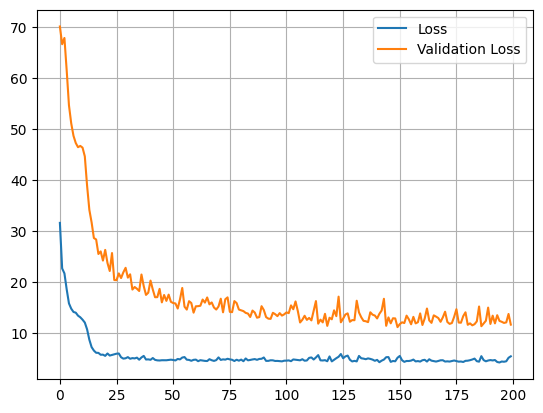

In [254]:
plt.plot(epoch_life, loss, label="Loss")
plt.plot(epoch_life, val_loss, label="Validation Loss")
plt.legend(loc=1)
plt.grid(True)
plt.show()

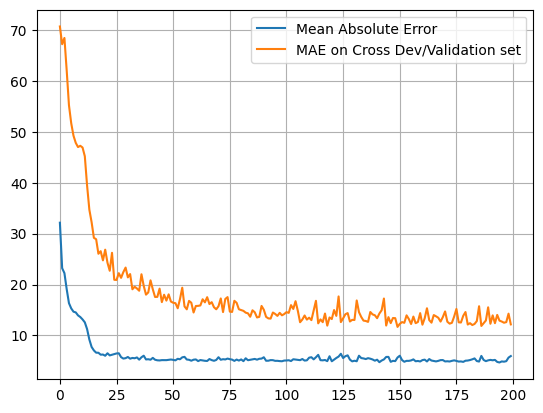

In [255]:
plt.plot(epoch_life, mae, label="Mean Absolute Error")
plt.plot(epoch_life, val_mae, label="MAE on Cross Dev/Validation set")
plt.grid(True)
plt.legend(loc=1)
plt.show()

In [256]:
# Checking layer weights:
print(l0.get_weights())

[array([[-0.01818079],
       [ 0.1912065 ],
       [ 0.10055635],
       [-0.61113757],
       [ 0.3810776 ],
       [ 0.50427145],
       [ 0.34359372],
       [-0.27050006],
       [-0.29284364],
       [-0.599938  ],
       [-0.19939002],
       [ 0.4729232 ],
       [-0.07678457],
       [ 0.02035385],
       [ 0.32861328]], dtype=float32), array([0.01500383], dtype=float32)]


In [257]:
series = np.array(series)

In [263]:
# Model with best validation mae selected; Tuning during training no longer yielding better results
# Model training for this not saved, however, same params and model architecture
model.load_weights('./checkpoints/ticket-price-seq-model-weights')

In [264]:
# Checking out by forecasting for 1 window
start = 960
output = model.predict(series[start: (start + window_size)][np.newaxis])
print("Actual Price: ${}".format(series[(start + window_size)]))
print("Predicted Price: ${}".format(output.squeeze()))

1/1 [==============================] - 0s 29ms/step
Actual Price: $146.15
Predicted Price: $139.86651611328125


In [273]:
series_to_forecast = series[split_time-window_size:-1]
forecast = model_forecast(model, series_to_forecast, window_size, batch_size)
forecast = np.squeeze(forecast)

      1/Unknown - 0s 36ms/step

7/7 [==============================] - 0s 9ms/step


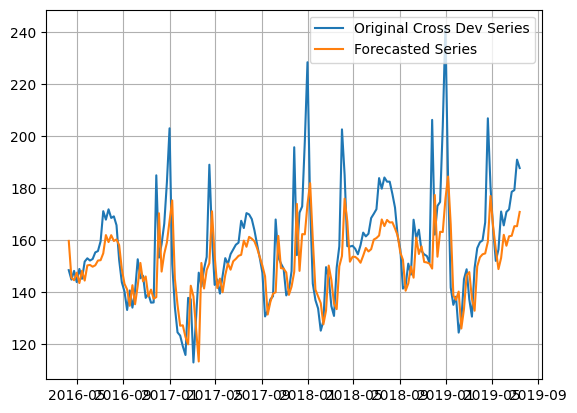

Mean Absolute Error for Forecasted Series: 10.946868896484375


In [274]:
plt.plot(time_valid, x_valid, label="Original Cross Dev Series")
plt.plot(time_valid, forecast, label="Forecasted Series")
plt.legend(loc=1)
plt.grid(True)
plt.show()

print("Mean Absolute Error for Forecasted Series: {}".format(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()))

In [267]:
# model.save_weights('./checkpoints/ticket-price-seq-model-weights')

In [329]:
def model_predict(model, time_series, series, num_iterations, window_size):
    last_time = max(time_series.tolist())
    days_to_add = datetime.timedelta(days=7)
    series = series.tolist()
    forecast = []
    time_forecast = []
    for i in range(num_iterations):
        input_series = np.array(series, dtype='float32')
        input_series = input_series.reshape((1, window_size))
        input_series = tf.convert_to_tensor(input_series)
        output = model.predict(input_series, verbose=0)
        series = series[1:]
        series.append(output)
        forecast.append(output)
        last_time = last_time + days_to_add
        time_forecast.append(last_time)
    
    return time_forecast, forecast

In [340]:
# Forecasting params
num_iterations = 20

In [341]:
time_forecast, predicted_prices = model_predict(model, time_valid, x_valid[-window_size:], num_iterations, window_size)
predicted_prices = np.squeeze(predicted_prices)

C:\Users\Admin\AppData\Local\Temp\ipykernel_36268\2162590377.py:8: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  input_series = np.array(series, dtype='float32')


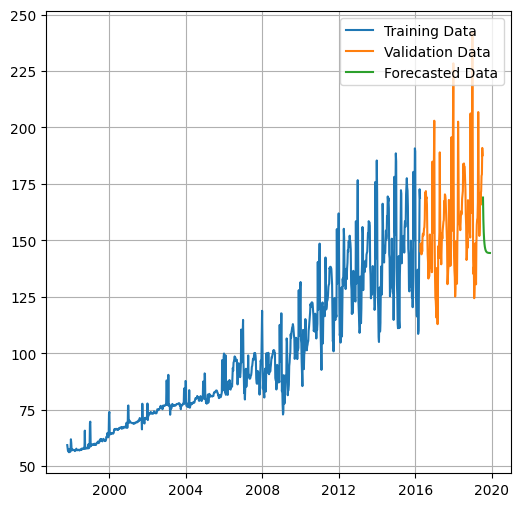

In [342]:
plt.figure(figsize=(6, 6))
plt.grid(True)
plt.plot(time_train, x_train, label="Training Data")
plt.plot(time_valid, x_valid, label="Validation Data")
plt.plot(time_forecast, predicted_prices, label="Forecasted Data")
plt.legend(loc=1)
plt.show()

### Chores: 
To perform sanity check, normalize data, and optionally set a benchmark for the model using statistical methods